In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Set a manual seed for reproducibility
torch.manual_seed(1)


In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # First fully connected layer
        self.relu = nn.ReLU()            # Activation function
        self.fc2 = nn.Linear(128, 10)    # Second fully connected layer

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = self.relu(self.fc1(x))  # Apply first layer and activation
        x = self.fc2(x)  # Apply second layer
        return x

In [3]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set model to training mode
    train_loss = []  # List to store training loss
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            train_loss.append(loss.item())  # Store loss
    return train_loss


In [4]:
def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in data_loader:
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)  # Update total count
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total_loss += criterion(outputs, labels).item()  # Accumulate loss
    accuracy = correct / total  # Calculate accuracy
    return accuracy, total_loss / len(data_loader)  # Return accuracy and average loss


In [5]:
def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in data_loader:
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)  # Update total count
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total_loss += criterion(outputs, labels).item()  # Accumulate loss
    accuracy = correct / total  # Calculate accuracy
    return accuracy, total_loss / len(data_loader)  # Return accuracy and average loss


In [6]:
def linear_interpolation(model1, model2, alpha):
    new_model = SimpleNN()  # Create a new model instance
    new_state_dict = {}
    for key in model1.state_dict():
        # Interpolate weights of the two models
        new_state_dict[key] = alpha * model1.state_dict()[key] + (1 - alpha) * model2.state_dict()[key]
    new_model.load_state_dict(new_state_dict)  # Load interpolated weights
    return new_model


In [7]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Load MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 55436794.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1858336.95it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12242660.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3604641.20it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# Define batch sizes
batch_size_m1 = 64
batch_size_m2 = 1024

# Create data loaders for training and testing
train_loader_m1 = DataLoader(mnist_train, batch_size=batch_size_m1, shuffle=True)
train_loader_m2 = DataLoader(mnist_train, batch_size=batch_size_m2, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)


In [9]:
# Initialize models
model_m1 = SimpleNN()
model_m2 = SimpleNN()

# Define the loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_m1 = optim.Adam(model_m1.parameters(), lr=1e-3)
optimizer_m2 = optim.Adam(model_m2.parameters(), lr=1e-2)


In [10]:
# Train models with different batch sizes
train_loss_m1 = train_model(model_m1, train_loader_m1, criterion, optimizer_m1)
train_loss_m2 = train_model(model_m2, train_loader_m2, criterion, optimizer_m2)


In [11]:
# Evaluate both models
accuracy_m1, _ = evaluate_model(model_m1, test_loader)
accuracy_m2, _ = evaluate_model(model_m2, test_loader)


In [15]:
# Define interpolation ratios
interpolation_ratios = torch.linspace(0, 1, 11)
interpolated_accuracies_train = []
interpolated_losses_train = []
interpolated_accuracies_test = []
interpolated_losses_test = []

# Evaluate interpolated models for each alpha
for alpha in interpolation_ratios:
    interpolated_model = linear_interpolation(model_m1, model_m2, alpha)

    # Evaluate on training and test sets
    accuracy_train, loss_train = evaluate_model(interpolated_model, train_loader_m1)
    accuracy_test, loss_test = evaluate_model(interpolated_model, test_loader)

    interpolated_accuracies_train.append(accuracy_train)
    interpolated_losses_train.append(loss_train)
    interpolated_accuracies_test.append(accuracy_test)
    interpolated_losses_test.append(loss_test)


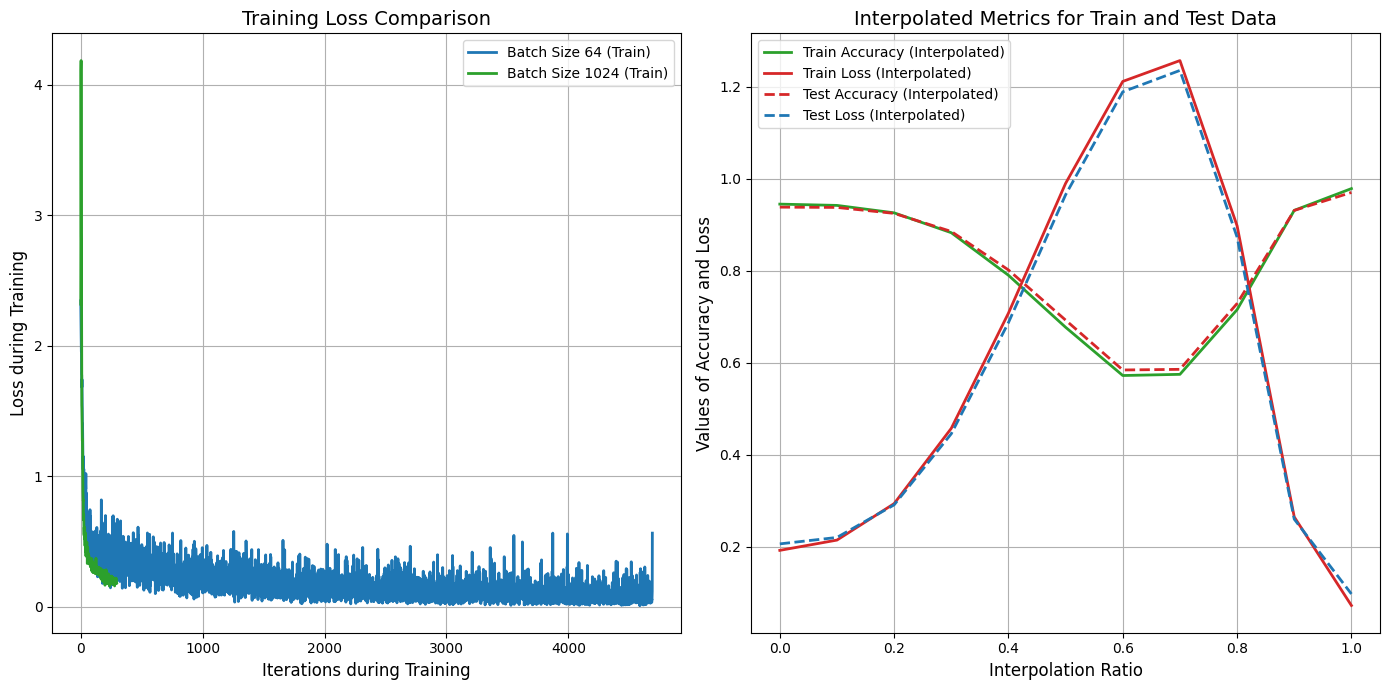

In [18]:
# Create side-by-side plots for loss and interpolated metrics
plt.figure(figsize=(14, 7))

# Plot the training loss for two batch sizes
plt.subplot(1, 2, 1)
plt.plot(train_loss_m1, label='Batch Size 64 (Train)', color='tab:blue', linewidth=2)
plt.plot(train_loss_m2, label='Batch Size 1024 (Train)', color='tab:green', linewidth=2)
plt.xlabel('Iterations during Training', fontsize=12)
plt.ylabel('Loss during Training', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Plot the interpolated metrics (accuracy and loss)
plt.subplot(1, 2, 2)
plt.plot(interpolation_ratios.numpy(), interpolated_accuracies_train, label='Train Accuracy (Interpolated)', color='tab:green', linewidth=2)
plt.plot(interpolation_ratios.numpy(), interpolated_losses_train, label='Train Loss (Interpolated)', color='tab:red', linewidth=2)
plt.plot(interpolation_ratios.numpy(), interpolated_accuracies_test, linestyle='--', label='Test Accuracy (Interpolated)', color='tab:red', linewidth=2)
plt.plot(interpolation_ratios.numpy(), interpolated_losses_test, linestyle='--', label='Test Loss (Interpolated)', color='tab:blue', linewidth=2)
plt.xlabel('Interpolation Ratio', fontsize=12)
plt.ylabel('Values of Accuracy and Loss', fontsize=12)
plt.title('Interpolated Metrics for Train and Test Data', fontsize=14)
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()
